<a href="https://colab.research.google.com/github/1230liutinghui/NAS/blob/main/regularized_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

导入nasbench_only108.tfrecord

In [5]:
%tensorflow_version 1.x

!curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord

!git clone https://github.com/google-research/nasbench
!pip install ./nasbench

from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench('nasbench_only108.tfrecord')

TensorFlow 1.x selected.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  498M  100  498M    0     0   164M      0  0:00:03  0:00:03 --:--:--  164M
fatal: destination path 'nasbench' already exists and is not an empty directory.
Processing ./nasbench
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for nasbench: filename=nasbench-1.0-py3-none-any.whl size=46788 sha256=7e1e8973832ddebf4cab05478ff245dfd37f534754b925463400ce1a9daf43a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-qhmr49tk/wheels/64/e0/f5/7eabfceccbb1

导入需要的modular，定义常量

In [6]:
# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'        # 3*3卷积层
CONV1X1 = 'conv1x1-bn-relu'        # 1*1卷积层
MAXPOOL3X3 = 'maxpool3x3'         # 3*3最大池化层
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]      # 可选操作集合
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

实现随机选择网络和网络的演化

In [7]:
"""
随机选择网络结构
"""
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec

"""
演化操作
"""
def mutate_spec(old_spec, mutation_rate=1.0):
  """Computes a valid mutated spec from the old_spec."""
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix)
    new_ops = copy.deepcopy(old_spec.original_ops)

    # In expectation, V edges flipped (note that most end up being pruned).
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          new_matrix[src, dst] = 1 - new_matrix[src, dst]
          
    # In expectation, one op is resampled.
    op_mutation_prob = mutation_rate / OP_SPOTS
    for ind in range(1, NUM_VERTICES - 1):
      if random.random() < op_mutation_prob:
        available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
        new_ops[ind] = random.choice(available)
        
    new_spec = api.ModelSpec(new_matrix, new_ops)
    if nasbench.is_valid(new_spec):
      return new_spec

In [8]:
# 定义一个model类
class Model(object):
  """A class representing a model.
  
  Attributes:
    arch: the architecture 
    accuracy: the simulated validation accuracy. 
  """
  def __init__(self):
    self.arch = None
    self.accuracy = None
    self.test = None

# 训练并评估网络结构，返回验证集和测试集上的准确率
def train_and_eval(arch):
  """Simulates training and evaluation.
  
  Computes the simulated validation accuracy of the given architecture. See
  the `accuracy` attribute in `Model` class for details.
  
  """
  data = nasbench.query(arch)
  return data['validation_accuracy'], data['test_accuracy']

实现遗传算法

In [3]:
import collections
import random

def regularized_evolution(cycles, population_size, sample_size):
  """Algorithm for regularized evolution (i.e. aging evolution).
  
  Args:
    cycles: the number of cycles the algorithm should run for.
    population_size: the number of individuals to keep in the population.
    sample_size: the number of individuals that should participate in each
        tournament.

  Returns:
    history: a list of `Model` instances, representing all the models computed
        during the evolution experiment.
  """
  population = collections.deque()         
  history = []  # Not used by the algorithm, only used to report results.

  # Initialize the population with random models.
  while len(population) < population_size:
    model = Model()
    model.arch = random_spec()
    model.accuracy, model.test = train_and_eval(model.arch)
    population.append(model)
    history.append(model)

  # Carry out evolution in cycles. Each cycle produces a model and removes
  # another.
  while len(history) < cycles:
    # Sample randomly chosen models from the current population.
    sample = []
    while len(sample) < sample_size:
      # Inefficient, but written this way for clarity. In the case of neural
      # nets, the efficiency of this line is irrelevant because training neural
      # nets is the rate-determining step.
      candidate = random.choice(list(population))
      sample.append(candidate)

    # The parent is the best model in the sample.
    parent = max(sample, key=lambda i: i.accuracy)

    # Create the child model and store it.
    child = Model()
    child.arch = mutate_spec(parent.arch)
    child.accuracy, child.test = train_and_eval(child.arch)
    population.append(child)
    history.append(child)

    # Remove the oldest model.
    population.popleft()

  return history

cycles设为10000进行遗传算法

In [20]:
from matplotlib.pyplot import MultipleLocator

xvalues = []
validation_values = []
test_values = []
temp = []       # 保存当前搜索的所有model
history = regularized_evolution(cycles=10000, population_size=100, sample_size=50)
for i in range(10001):
  temp = history[0:i+1]
  high = max(temp, key=lambda i: i.accuracy)
  xvalues.append(i)
  validation_values.append(high.accuracy)
  test_values.append(high.test)

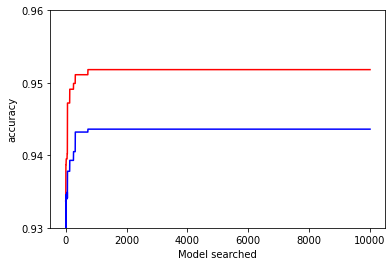

In [25]:
plt.plot(xvalues, validation_values, color='red', label='validation')
plt.plot(xvalues, test_values, color='blue', label='test')
plt.xlabel('Model searched')
plt.ylabel('accuracy')
x_major_locator=MultipleLocator(2000)
y_major_locator=MultipleLocator(0.01)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.ylim(0.93, 0.96)
plt.show()

循环执行遗传算法，观察不同初始种群和cycles下的差异

In [9]:
x = []
validation = []
test = []
for i in range(1,10001,100):
  res = regularized_evolution(cycles=i, population_size=100, sample_size=50)
  x.append(len(res))
  high = max(res, key=lambda i: i.accuracy)
  validation.append(high.accuracy)
  test.append(high.test)

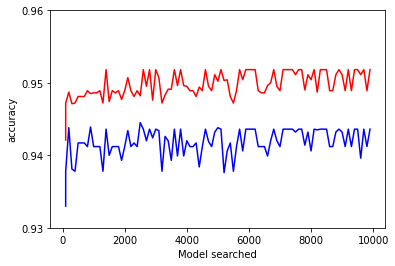

In [11]:
from matplotlib.pyplot import MultipleLocator
plt.plot(x, validation, color='red', label='validation')
plt.plot(x, test, color='blue', label='test')
plt.xlabel('Model searched')
plt.ylabel('accuracy')
x_major_locator=MultipleLocator(2000)
y_major_locator=MultipleLocator(0.01)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.ylim(0.93, 0.96)
plt.show()